# 03 — EDA and target definition (DepMap × PRISM)

## Objective

This notebook performs exploratory data analysis (EDA) on the processed DepMap–PRISM dataset and defines the modeling targets for downstream machine learning.

The goals of this step are to:

- Characterize the distribution of drug response (AUC)
- Identify well-behaved and heterogeneous compounds
- Evaluate target variability and signal strength
- Define the modeling strategy (regression vs classification)
- Select a subset of drugs for initial modeling

This notebook operates exclusively on datasets generated in **Notebook 02**.

---

## Inputs

- `prism_auc_filtered.parquet`
- `drug_index.parquet`
- `depmap_expression_matched.parquet`

---

## Outputs

- EDA figures and summary tables  
- Selected drug list for modeling  
- Target definition artifacts (if applicable)

---

## Scope

No model training or feature engineering is performed here.  
This step is limited to data exploration and modeling design decisions.

---


## Imports & configuration

In [1]:
import pandas as pd
import numpy as np

from pathlib import Path
import json
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Project paths
PROJECT_ROOT = Path("..")

DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"
REPORTS_DIR = PROJECT_ROOT / "reports"
FIGURES_DIR = PROJECT_ROOT / "figures"

FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# Modeling parameters (initial defaults)
TARGET_COL = "auc"

# For later decisions
MIN_CELL_LINES_PER_DRUG = 200

# Plotting colors
COLOR_MAIN = "#34495E"
COLOR_ACCENT = "#7F8C8D"

# Create directory for document figures
FIGURES_DIR = PROJECT_ROOT / "figures" / "doc_figures"
FIGURES_DIR.mkdir(parents=True, exist_ok=True)


## Load processed datasets (from Notebook 02)

In [3]:
# Data loading
prism_filtered_path = DATA_PROCESSED / "prism_auc_filtered.parquet"
drug_index_path = DATA_PROCESSED / "drug_index.parquet"
expr_path = DATA_PROCESSED / "depmap_expression_matched.parquet"

prism = pd.read_parquet(prism_filtered_path)
drug_index = pd.read_parquet(drug_index_path)
X_expr = pd.read_parquet(expr_path)

print("PRISM filtered:", prism.shape)
print("Drug index:", drug_index.shape)
print("Expression matrix:", X_expr.shape)

PRISM filtered: (732066, 5)
Drug index: (1528, 7)
Expression matrix: (751, 19220)


In [4]:
# Basic EDA
print("Unique cell lines (PRISM):", prism["join_id"].nunique())
print("Unique drugs (PRISM):", prism["broad_id"].nunique())
print("Unique cell lines (expression):", X_expr.index.nunique())

missing_targets = prism[TARGET_COL].isna().sum()
print("Missing targets:", missing_targets)


Unique cell lines (PRISM): 727
Unique drugs (PRISM): 1528
Unique cell lines (expression): 727
Missing targets: 0


## Global distribution of PRISM AUC

In [5]:
# Target variable summary
auc_summary = prism[TARGET_COL].describe()
auc_summary

count    732066.000000
mean          0.943213
std           0.281977
min           0.000000
25%           0.793331
50%           0.907206
75%           1.100662
max           4.889162
Name: auc, dtype: float64

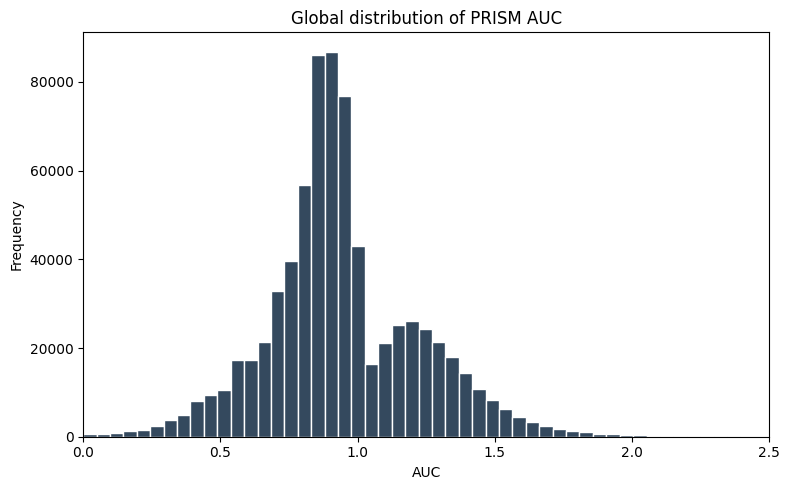

Saved figure to: ..\figures\doc_figures\03_auc_global_hist.png


In [6]:
# Global distribution of PRISM AUC
plt.figure(figsize=(8, 5))
plt.hist(prism[TARGET_COL], bins=100, color=COLOR_MAIN, edgecolor="white")
plt.xlabel("AUC")
plt.ylabel("Frequency")
plt.xlim(0, 2.5)
plt.title("Global distribution of PRISM AUC")
plt.tight_layout()

# Save figure
fig_path = FIGURES_DIR / "03_auc_global_hist.png"
plt.savefig(fig_path, dpi=200, bbox_inches="tight")
plt.show()

print(f"Saved figure to: {fig_path}")

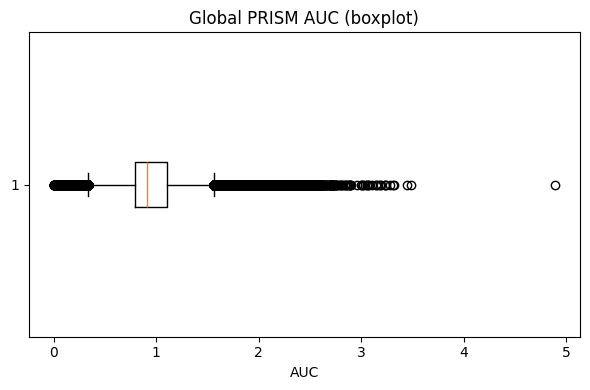

In [7]:
# Boxplot of PRISM AUC
plt.figure(figsize=(6, 4))
plt.boxplot(prism[TARGET_COL], vert=False)
plt.xlabel("AUC")
plt.title("Global PRISM AUC (boxplot)")
plt.tight_layout()
plt.show()

## Drug-level AUC heterogeneity

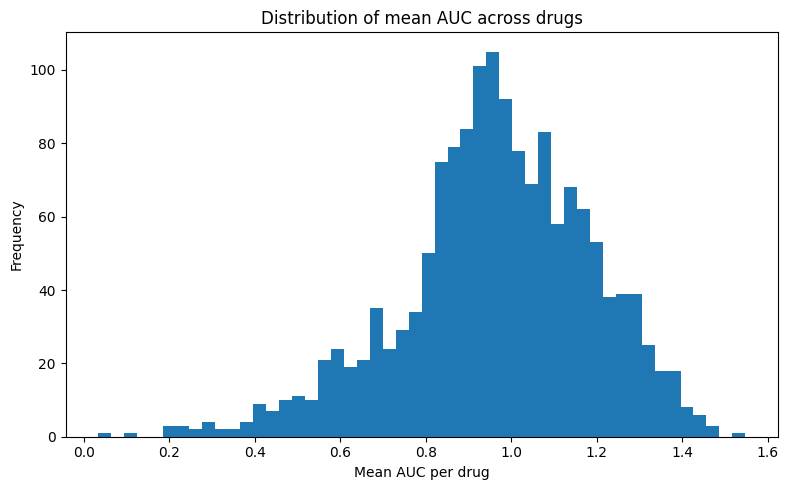

In [8]:
# Distribution of mean AUC across drugs
plt.figure(figsize=(8, 5))
plt.hist(drug_index["auc_mean"], bins=50)
plt.xlabel("Mean AUC per drug")
plt.ylabel("Frequency")
plt.title("Distribution of mean AUC across drugs")
plt.tight_layout()
plt.show()

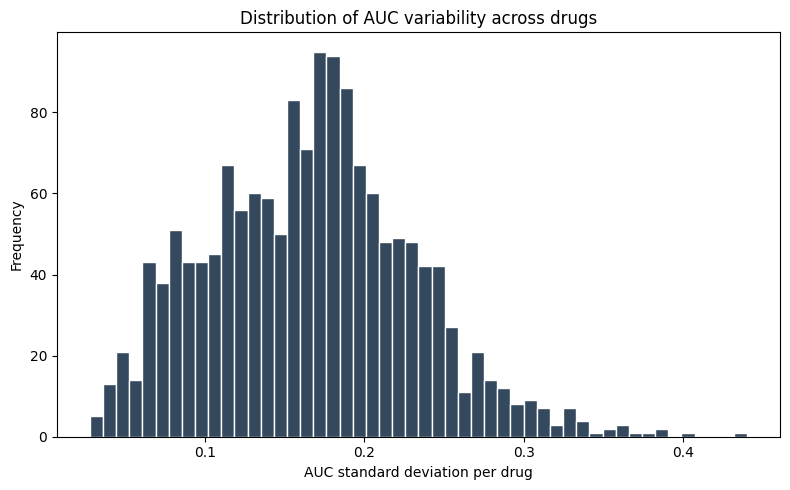

Saved figure to: ..\figures\doc_figures\03_auc_std_hist.png


In [9]:
# Distribution of AUC standard deviation across drugs
plt.figure(figsize=(8, 5))
plt.hist(drug_index["auc_std"], bins=50, color=COLOR_MAIN, edgecolor="white")
plt.xlabel("AUC standard deviation per drug")
plt.ylabel("Frequency")
plt.title("Distribution of AUC variability across drugs")
plt.tight_layout()

# Save figure
fig_path = FIGURES_DIR / "03_auc_std_hist.png"
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Saved figure to: {fig_path}")

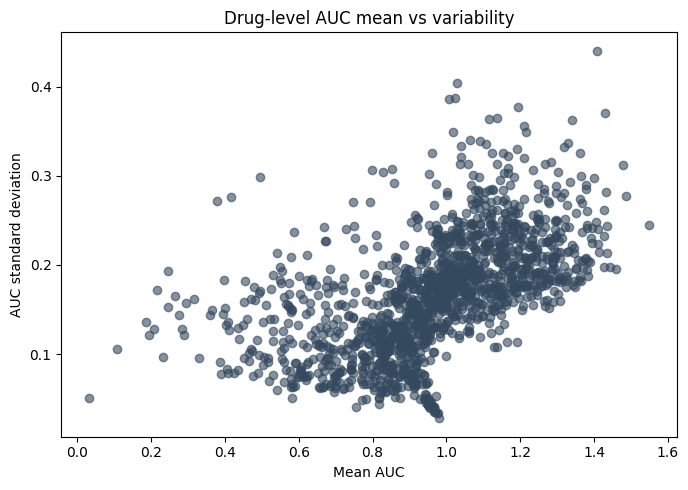

Saved figure to: ..\figures\doc_figures\03_auc_mean_vs_std.png


In [10]:
# Scatter plot of mean AUC vs standard deviation
plt.figure(figsize=(7, 5))
plt.scatter(
    drug_index["auc_mean"],
    drug_index["auc_std"],
    color=COLOR_MAIN,
    alpha=0.6
)
plt.xlabel("Mean AUC")
plt.ylabel("AUC standard deviation")
plt.title("Drug-level AUC mean vs variability")
plt.tight_layout()

# Save figure
fig_path = FIGURES_DIR / "03_auc_mean_vs_std.png"
plt.savefig(fig_path, dpi=200, bbox_inches="tight")
plt.show()

print(f"Saved figure to: {fig_path}")

## Select subset of drugs for initial modeling

In [11]:
# Criteria for selecting drugs for modeling
MIN_STD = 0.15
MIN_MEAN = 0.6
MAX_MEAN = 1.3
TOP_N = 100

In [12]:
# Filter drugs based on criteria
candidate_drugs = drug_index[
    (drug_index["auc_std"] >= MIN_STD) &
    (drug_index["auc_mean"] >= MIN_MEAN) &
    (drug_index["auc_mean"] <= MAX_MEAN)
].copy()

print("Candidate drugs after filtering:", len(candidate_drugs))

Candidate drugs after filtering: 811


In [13]:
# Sort candidate drugs by number of cell lines and AUC std
candidate_drugs = candidate_drugs.sort_values(
    by=["n_cell_lines", "auc_std"],
    ascending=[False, False]
)

candidate_drugs.head(10)

,broad_id,name,n_cell_lines,auc_mean,auc_std,auc_min,auc_max
3,BRD-K95142244-001-01-5,talazoparib,711,0.684250,0.195109,0.117250,1.807046
10,BRD-K50168500-001-07-9,canertinib,707,0.915852,0.153452,0.305531,1.792206
16,BRD-K33610132-001-02-9,rociletinib,704,0.959678,0.178074,0.535787,2.882057
19,BRD-A70858459-001-01-7,estramustine,699,1.004251,0.181686,0.492309,1.954327
34,BRD-K77625799-001-07-7,vandetanib,690,1.006869,0.196001,0.625323,2.260526
44,BRD-K42898655-001-01-8,temsirolimus,688,0.621757,0.182597,0.177003,1.699573
48,BRD-K29905972-001-06-3,axitinib,687,0.917758,0.151781,0.459816,2.125014
50,BRD-K57080016-001-15-9,selumetinib,686,0.960898,0.325172,0.400360,3.147787
58,BRD-K89014967-001-04-3,AS-703026,683,0.694561,0.175278,0.249734,1.482271
65,BRD-K14109347-001-03-4,LY2603618,679,0.922215,0.251157,0.555696,2.608402


In [14]:
# Select top N drugs
selected_drugs = candidate_drugs.head(TOP_N).copy()

print("Selected drugs:", len(selected_drugs))
print("Min std among selected:", selected_drugs["auc_std"].min())
print("Mean std among selected:", selected_drugs["auc_std"].mean())

Selected drugs: 100
Min std among selected: 0.1514038934886878
Mean std among selected: 0.1942798012688355


## Save selected drugs for downstream modeling

In [15]:
# Save selected drugs
selected_drugs_path = DATA_PROCESSED / "selected_drugs.parquet"
selected_drugs.to_parquet(selected_drugs_path, index=False)

print(f"Saved selected drugs to: {selected_drugs_path}")


Saved selected drugs to: ..\data\processed\selected_drugs.parquet


In [16]:
# Save selection summary
selection_summary = {
    "target_column": TARGET_COL,
    "min_cell_lines_per_drug": MIN_CELL_LINES_PER_DRUG,
    "selection_filters": {
        "MIN_STD": MIN_STD,
        "MIN_MEAN": MIN_MEAN,
        "MAX_MEAN": MAX_MEAN,
    },
    "top_n": TOP_N,
    "n_candidates": int(len(candidate_drugs)),
    "n_selected": int(len(selected_drugs)),
    "selected_min_std": float(selected_drugs["auc_std"].min()),
    "selected_mean_std": float(selected_drugs["auc_std"].mean()),
}

selection_summary_path = REPORTS_DIR / "03_selected_drugs_summary.json"

with open(selection_summary_path, "w") as f:
    json.dump(selection_summary, f, indent=2)

print(f"Saved selection summary to: {selection_summary_path}")

Saved selection summary to: ..\reports\03_selected_drugs_summary.json


## Target definition and modeling strategy

The primary modeling target in this project is the continuous PRISM AUC value.

At this stage, the modeling strategy is defined as:

- **Primary task**: Regression  
  Predict continuous drug response (AUC) from gene expression profiles.

- **Rationale**:
  - The AUC distribution is non-degenerate and continuous.
  - Drug-level variability is substantial across cell lines.
  - Regression preserves maximal information from the response signal.
  - Binarization would introduce arbitrary thresholds and information loss.

- **Secondary task (future extension)**:
  Binary sensitivity classification (sensitive vs resistant) may be explored
  as a downstream extension using drug-specific thresholds or quantile splits.

This notebook therefore defines **regression as the canonical modeling setup**.

In [17]:
# Define and save target definition
target_definition = {
    "primary_task": "regression",
    "target_column": TARGET_COL,
    "rationale": [
        "AUC is continuous and non-degenerate",
        "Drug-level response shows substantial heterogeneity",
        "Regression preserves maximal response information",
        "Avoids arbitrary binarization thresholds",
    ],
    "secondary_task_future": "binary_classification",
}

target_definition_path = REPORTS_DIR / "03_target_definition.json"

with open(target_definition_path, "w") as f:
    json.dump(target_definition, f, indent=2)

print(f"Saved target definition to: {target_definition_path}")


Saved target definition to: ..\reports\03_target_definition.json
